In [1]:
import numpy as np
import pandas as pd
import json

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

2025-12-08 17:20:54.345155: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-12-08 17:20:54.413467: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-12-08 17:20:54.434187: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-12-08 17:20:54.501935: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-12-08 17:20:57.219032: W tensorflow/compiler/tf2

In [2]:
# Configuration
def load_parameters(path):
    """Load parameters from a JSON file into a dictionary"""
    with open(path, 'r') as f:
        params = json.load(f)
    
    print(f"Using parameters: {params}")
    return params

# Load configuration from JSON file
params = load_parameters('./config.json')
SELECT_MODEL = params.get('SELECT_MODEL', 0)
FORECAST_HORIZON = params.get('FORECAST_HORIZON', 1)
NUM_EPOCHS = params.get('NUM_EPOCHS', 10)
BATCH_SIZE = params.get('BATCH_SIZE', 32)

saved_model_path = "./saved-model/"

Using parameters: {'SEQUENCE_LENGTH': 48, 'STEP_SIZE': 24, 'FORECAST_HORIZON': 1, 'BATCH_SIZE': 32, 'NUM_EPOCHS': 10, 'SELECT_MODEL': 0}


In [3]:
# Load preprocessed feature data
X_train_feature = np.load(f"./data/finalized/X_train_feature_{SELECT_MODEL}.npy")
Y_train_feature = np.load(f"./data/finalized/Y_train_feature_{SELECT_MODEL}.npy")
X_val_feature = np.load(f"./data/finalized/X_val_feature_{SELECT_MODEL}.npy")
Y_val_feature = np.load(f"./data/finalized/Y_val_feature_{SELECT_MODEL}.npy")
X_test_feature = np.load(f"./data/finalized/X_test_feature_{SELECT_MODEL}.npy")
Y_test_feature = np.load(f"./data/finalized/Y_test_feature_{SELECT_MODEL}.npy")

In [4]:
def create_cnn_model(seq_length, forecast_horizon):
    """
    Simple 1D CNN for time-series regression built with TensorFlow/Keras.
    Architecture: Conv1D -> MaxPool -> Dense -> Output
    """
    model = models.Sequential([
        layers.Input(shape=(seq_length, 1)),
        layers.Conv1D(filters=64, kernel_size=5, activation='relu', padding='valid'),
        layers.Dropout(0.25),
        layers.MaxPooling1D(pool_size=2),
        layers.Flatten(),
        layers.Dense(50, activation='relu'),
        layers.Dropout(0.25),
        layers.Dense(forecast_horizon)
    ])
    
    return model

In [5]:
def evaluate_model(model, X_test, Y_test):
    """Run predictions"""
    y_pred = model.predict(X_test, verbose=0)
    y_true = Y_test
    
    return y_true, y_pred

def print_metrics(y_true, y_pred, model_name="Model"):
    """Print regression metrics"""
    # Calculate metrics
    mse = mean_squared_error(y_true.flatten(), y_pred.flatten())
    mae = mean_absolute_error(y_true.flatten(), y_pred.flatten())
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true.flatten(), y_pred.flatten())
    
    print(f"\n{model_name} Regression Metrics:")
    print(f"Mean Squared Error (MSE): {mse:.4f}")
    print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
    print(f"Mean Absolute Error (MAE): {mae:.4f}")
    print(f"R² Score: {r2:.4f}")
    
    return y_true, y_pred, mse, mae, rmse, r2

def evaluate_and_print_metrics(model, X_test, Y_test, model_name="Model"):
    y_true, y_pred = evaluate_model(model, X_test, Y_test)
    return print_metrics(y_true, y_pred, model_name)

In [6]:
# Build the TensorFlow/Keras CNN model
model = create_cnn_model(X_train_feature.shape[1], FORECAST_HORIZON)

# Compile the model
model.compile(
    optimizer='adam',
    loss='mse',
    metrics=['mae']
)

model.summary()
print("\nModel Architecture:")

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 44, 64)         │           384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 44, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 22, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1408)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 50)             │        70,450 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 70,885 (276.89 KB)

 Trainable params: 70,885 (276.89 KB)

 Non-trainable params: 0 (0.00 B)


Model Architecture:


In [7]:
# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)
callbacks = [early_stopping, reduce_lr]

# Train the model
history = model.fit(
    X_train_feature,
    Y_train_feature,
    validation_data=(X_val_feature, Y_val_feature),
    epochs=NUM_EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/10
185/185 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - loss: 0.0400 - mae: 0.1539 - val_loss: 0.0328 - val_mae: 0.1412 - learning_rate: 0.0010
Epoch 2/10
185/185 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - loss: 0.0400 - mae: 0.1539 - val_loss: 0.0328 - val_mae: 0.1412 - learning_rate: 0.0010
Epoch 2/10
185/185 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.0329 - mae: 0.1409 - val_loss: 0.0363 - val_mae: 0.1488 - learning_rate: 0.0010
Epoch 3/10
185/185 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.0329 - mae: 0.1409 - val_loss: 0.0363 - val_mae: 0.1488 - learning_rate: 0.0010
Epoch 3/10
185/185 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.0321 - mae: 0.1409 - val_loss: 0.0320 - val_mae: 0.1388 - learning_rate: 0.0010
Epoch 4/10
185/185 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.0321 - mae: 0.1409 - val_loss: 0.0320 - val_mae: 0.1388 - learning_rate: 0.0010
Epoch 4/10
185/185 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.0316 - mae: 0.1388 - val_loss: 0.0303 - val_mae: 0.1339 - learning_rate: 0.0010

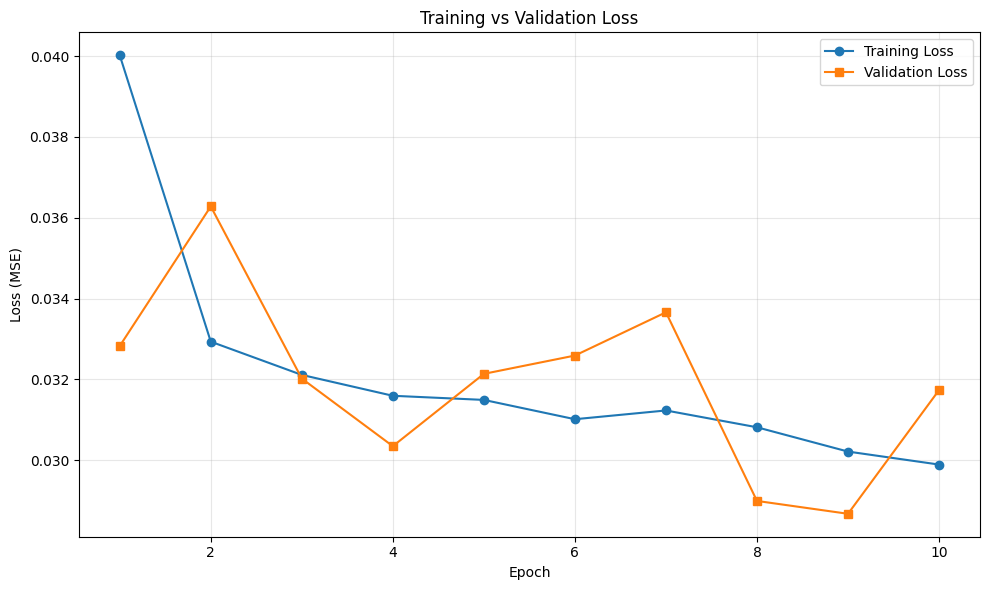


Final Training Loss: 0.0299
Final Validation Loss: 0.0317
Difference (Val - Train): 0.0018
Ratio (Val / Train): 1.06


In [8]:
# Plot training and validation loss
import matplotlib.pyplot as plt

train_losses = history.history['loss']
val_losses = history.history['val_loss']

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Training Loss', marker='o')
plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss', marker='s')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.title('Training vs Validation Loss')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Check for overfitting
final_train_loss = train_losses[-1]
final_val_loss = val_losses[-1]
loss_diff = final_val_loss - final_train_loss
loss_ratio = final_val_loss / final_train_loss

print(f"\nFinal Training Loss: {final_train_loss:.4f}")
print(f"Final Validation Loss: {final_val_loss:.4f}")

print(f"Difference (Val - Train): {loss_diff:.4f}")
print(f"Ratio (Val / Train): {loss_ratio:.2f}")

In [9]:
# Evaluate the model
print("\n--- Evaluating Model Performance ---")
y_true, y_pred, mse, mae, rmse, r2 = evaluate_and_print_metrics(model, X_test_feature, Y_test_feature)


--- Evaluating Model Performance ---

Model Regression Metrics:
Mean Squared Error (MSE): 0.0287
Root Mean Squared Error (RMSE): 0.1695
Mean Absolute Error (MAE): 0.1346
R² Score: 0.8703

Model Regression Metrics:
Mean Squared Error (MSE): 0.0287
Root Mean Squared Error (RMSE): 0.1695
Mean Absolute Error (MAE): 0.1346
R² Score: 0.8703


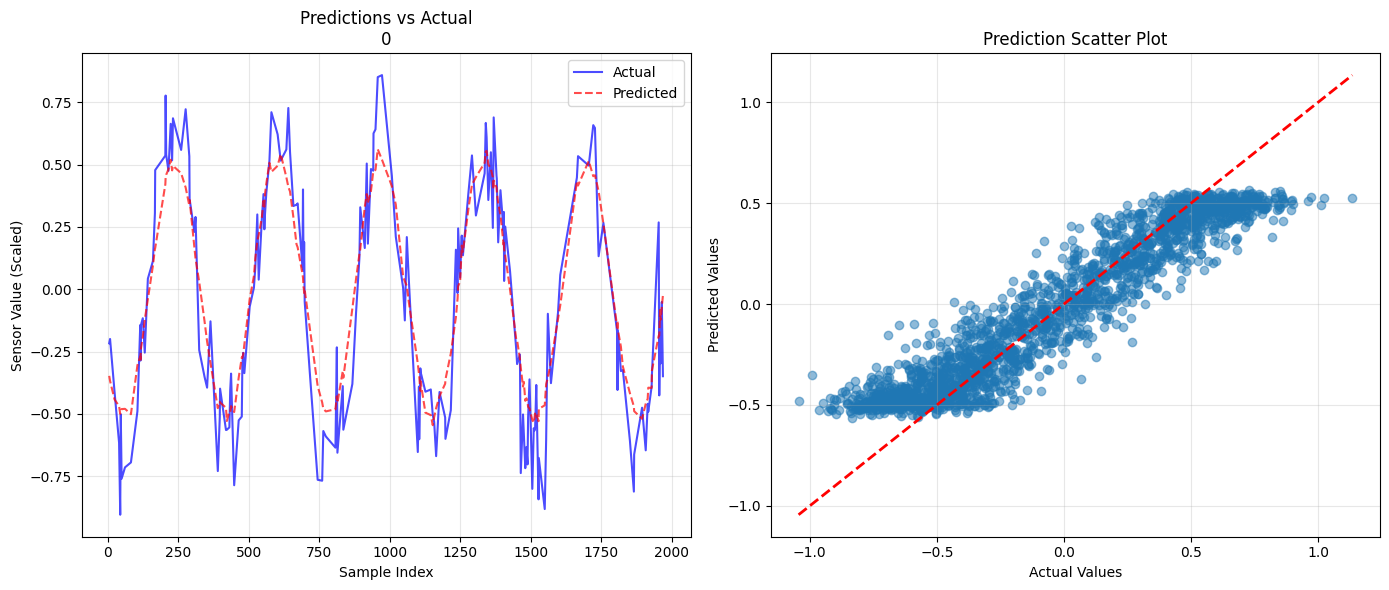

In [10]:
y_true_flat = np.array(y_true).reshape(-1)
y_pred_flat = np.array(y_pred).reshape(-1)

plt.figure(figsize=(14, 6))

# Sample a subset for visualization if too many points
num_samples = min(200, len(y_true_flat))
if num_samples == 0:
    print("No test samples available to plot.")
else:
    indices = np.random.choice(len(y_true_flat), num_samples, replace=False)
    indices = np.sort(indices)

    plt.subplot(1, 2, 1)
    plt.plot(indices, y_true_flat[indices], 'b-', label='Actual', alpha=0.7)
    plt.plot(indices, y_pred_flat[indices], 'r--', label='Predicted', alpha=0.7)
    plt.xlabel('Sample Index')
    plt.ylabel('Sensor Value (Scaled)')
    plt.title(f'Predictions vs Actual\n{SELECT_MODEL}')
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.subplot(1, 2, 2)
    plt.scatter(y_true_flat, y_pred_flat, alpha=0.5)
    mn = min(y_true_flat.min(), y_pred_flat.min())
    mx = max(y_true_flat.max(), y_pred_flat.max())
    plt.plot([mn, mx], [mn, mx], 'r--', lw=2)
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.title('Prediction Scatter Plot')
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

# Pruning the Model

In [11]:
import tf2onnx
import tempfile
import os
from onnxruntime.quantization import quantize_dynamic, QuantType

In [12]:
def structured_prune_model(model, target_sparsity=0.5):
    """
    Perform structured pruning on the model by removing entire filters/neurons.
    This approach is more hardware-friendly than unstructured pruning.
    
    Args:
        model: The trained Keras model to prune
        target_sparsity: Target sparsity ratio (e.g., 0.5 means remove 50% of filters/neurons)
    
    Returns:
        pruned_model: A new model with reduced filters/neurons
    """
    print(f"\n=== Structured Pruning (Target Sparsity: {target_sparsity*100:.0f}%) ===")
    
    # 1. Analyze each layer and determine pruning strategy
    print("\nAnalyzing layers for pruning...")
    layer_configs = []
    
    for i, layer in enumerate(model.layers):
        layer_config = {
            'name': layer.name,
            'class': layer.__class__.__name__,
            'original_layer': layer
        }
        
        if isinstance(layer, tf.keras.layers.Conv1D):
            original_filters = layer.filters
            # Prune filters based on L1 norm of weights
            weights = layer.get_weights()[0]  # Shape: (kernel_size, in_channels, out_channels)
            
            # Calculate L1 norm for each filter
            filter_norms = np.sum(np.abs(weights), axis=(0, 1))  # Sum over kernel_size and in_channels
            
            # Determine how many filters to keep
            num_keep = max(1, int(original_filters * (1 - target_sparsity)))
            
            # Get indices of filters to keep (those with highest L1 norms)
            keep_indices = np.argsort(filter_norms)[-num_keep:]
            keep_indices = np.sort(keep_indices)  # Keep in original order
            
            layer_config['new_filters'] = num_keep
            layer_config['keep_indices'] = keep_indices
            layer_config['original_filters'] = original_filters
            
            print(f"Pruning {layer.name}: {original_filters} -> {num_keep} filters")
            
        elif isinstance(layer, tf.keras.layers.Dense):
            # Check if this is the output layer
            if i == len(model.layers) - 1:
                print(f"Skipping pruning for output layer {layer.name}")
                layer_config['prune'] = False
            else:
                original_units = layer.units
                # Prune neurons based on L1 norm of weights
                weights = layer.get_weights()[0]  # Shape: (input_dim, units)
                
                # Calculate L1 norm for each neuron
                neuron_norms = np.sum(np.abs(weights), axis=0)
                
                # Determine how many neurons to keep
                num_keep = max(1, int(original_units * (1 - target_sparsity)))
                
                # Get indices of neurons to keep
                keep_indices = np.argsort(neuron_norms)[-num_keep:]
                keep_indices = np.sort(keep_indices)
                
                layer_config['new_units'] = num_keep
                layer_config['keep_indices'] = keep_indices
                layer_config['original_units'] = original_units
                layer_config['prune'] = True
                
                print(f"Pruning {layer.name}: {original_units} -> {num_keep} units")
        
        layer_configs.append(layer_config)
    
    # 2. Build new model with pruned architecture
    print("\nRebuilding model with pruned architecture...")
    pruned_model = models.Sequential()
    
    for i, config in enumerate(layer_configs):
        original_layer = config['original_layer']
        
        if config['class'] == 'InputLayer':
            pruned_model.add(layers.Input(shape=original_layer.input_shape[0][1:]))
            
        elif config['class'] == 'Conv1D':
            new_conv = layers.Conv1D(
                filters=config['new_filters'],
                kernel_size=original_layer.kernel_size,
                strides=original_layer.strides,
                padding=original_layer.padding,
                activation=original_layer.activation,
                name=original_layer.name
            )
            pruned_model.add(new_conv)
            
        elif config['class'] == 'Dropout':
            pruned_model.add(layers.Dropout(
                rate=original_layer.rate,
                name=original_layer.name
            ))
            
        elif config['class'] == 'MaxPooling1D':
            pruned_model.add(layers.MaxPooling1D(
                pool_size=original_layer.pool_size,
                strides=original_layer.strides,
                padding=original_layer.padding,
                name=original_layer.name
            ))
            
        elif config['class'] == 'Flatten':
            pruned_model.add(layers.Flatten(name=original_layer.name))
            
        elif config['class'] == 'Dense':
            if config.get('prune', True):
                new_dense = layers.Dense(
                    units=config['new_units'],
                    activation=original_layer.activation,
                    name=original_layer.name
                )
            else:
                # Output layer - keep original size
                new_dense = layers.Dense(
                    units=original_layer.units,
                    activation=original_layer.activation,
                    name=original_layer.name
                )
            pruned_model.add(new_dense)
    
    # 3. Build the model with correct input shape
    pruned_model.build((None,) + model.input_shape[1:])
    
    # 4. Transfer weights from original to pruned model
    print("\nTransferring weights...")
    
    # Create a dummy input to get intermediate outputs
    dummy_input = np.zeros((1,) + model.input_shape[1:])
    
    for i, config in enumerate(layer_configs):
        if config['class'] in ['InputLayer', 'Dropout', 'MaxPooling1D', 'Flatten']:
            continue
            
        original_layer = config['original_layer']
        pruned_layer = pruned_model.get_layer(name=original_layer.name)
        
        if config['class'] == 'Conv1D':
            # Transfer selected filters
            old_weights = original_layer.get_weights()
            kernel, bias = old_weights[0], old_weights[1]
            
            # Select filters to keep: shape (kernel_size, in_channels, out_channels)
            keep_indices = config['keep_indices']
            new_kernel = kernel[:, :, keep_indices]
            new_bias = bias[keep_indices]
            
            pruned_layer.set_weights([new_kernel, new_bias])
            
        elif config['class'] == 'Dense' and config.get('prune', True):
            # Transfer selected neurons
            old_weights = original_layer.get_weights()
            
            # Find the previous non-trivial layer that outputs to this Dense layer
            # We need to determine which outputs to keep based on previous pruning
            prev_layer_idx = i - 1
            while prev_layer_idx >= 0:
                prev_config = layer_configs[prev_layer_idx]
                if prev_config['class'] in ['Conv1D', 'Dense']:
                    break
                prev_layer_idx -= 1
            
            if prev_layer_idx >= 0:
                prev_config = layer_configs[prev_layer_idx]
                
                if prev_config['class'] == 'Conv1D':
                    # After Conv1D -> Pool -> Flatten, the input dimension changes
                    # We need to map which flattened indices correspond to which filters
                    prev_keep = prev_config['keep_indices']
                    
                    # Get the shape after the conv layer
                    # For this model: Conv1D(64) -> MaxPool(2) -> Flatten
                    # Original: seq_length after conv and pool
                    # We need to compute this dynamically
                    
                    # Build a temporary model to get the flattened shape
                    temp_model = models.Sequential()
                    for j in range(i):
                        if layer_configs[j]['class'] == 'InputLayer':
                            temp_model.add(layers.Input(shape=model.input_shape[1:]))
                        elif layer_configs[j]['class'] != 'InputLayer':
                            temp_model.add(layer_configs[j]['original_layer'])
                    
                    temp_output = temp_model.predict(dummy_input, verbose=0)
                    original_flat_size = temp_output.shape[1]
                    
                    # Now do the same for pruned model
                    temp_pruned = models.Sequential()
                    for j in range(len(pruned_model.layers)):
                        if j < len(pruned_model.layers) - 1:  # Exclude the current Dense layer
                            temp_pruned.add(pruned_model.layers[j])
                        else:
                            break
                    
                    # Check if we've reached the Flatten layer
                    if len(temp_pruned.layers) > 0:
                        temp_pruned_output = temp_pruned.predict(dummy_input, verbose=0)
                        new_flat_size = temp_pruned_output.shape[1]
                        
                        # Calculate the mapping
                        # Original flattened shape is (seq_len_after_pool, num_filters_orig)
                        # New flattened shape is (seq_len_after_pool, num_filters_new)
                        seq_len_after_pool = original_flat_size // prev_config['original_filters']
                        
                        # Build index mapping for the flattened dimension
                        keep_flat_indices = []
                        for filter_idx in prev_keep:
                            for t in range(seq_len_after_pool):
                                original_idx = t * prev_config['original_filters'] + filter_idx
                                keep_flat_indices.append(original_idx)
                        keep_flat_indices = np.array(keep_flat_indices)
                        
                        # Prune input dimension
                        kernel = old_weights[0][keep_flat_indices, :]
                    else:
                        kernel = old_weights[0]
                
                elif prev_config['class'] == 'Dense':
                    # Dense -> Dense connection
                    prev_keep = prev_config['keep_indices']
                    kernel = old_weights[0][prev_keep, :]
                else:
                    kernel = old_weights[0]
            else:
                kernel = old_weights[0]
            
            # Prune output dimension
            keep_indices = config['keep_indices']
            kernel = kernel[:, keep_indices]
            bias = old_weights[1][keep_indices]
            
            pruned_layer.set_weights([kernel, bias])
            
        elif config['class'] == 'Dense' and not config.get('prune', True):
            # Output layer - need to handle input pruning
            old_weights = original_layer.get_weights()
            
            # Find previous layer
            prev_layer_idx = i - 1
            while prev_layer_idx >= 0:
                prev_config = layer_configs[prev_layer_idx]
                if prev_config['class'] in ['Dense']:
                    break
                prev_layer_idx -= 1
            
            if prev_layer_idx >= 0:
                prev_config = layer_configs[prev_layer_idx]
                if prev_config['class'] == 'Dense' and prev_config.get('prune', True):
                    prev_keep = prev_config['keep_indices']
                    kernel = old_weights[0][prev_keep, :]
                    bias = old_weights[1]
                    pruned_layer.set_weights([kernel, bias])
                else:
                    pruned_layer.set_weights(old_weights)
            else:
                pruned_layer.set_weights(old_weights)
    
    print(f"\nStructured pruning complete!")
    print(f"Original model parameters: {model.count_params():,}")
    print(f"Pruned model parameters: {pruned_model.count_params():,}")
    print(f"Parameter reduction: {(1 - pruned_model.count_params()/model.count_params())*100:.1f}%")
    
    return pruned_model

# Apply structured pruning to the trained model
pruned_model = structured_prune_model(model, target_sparsity=0.5)

# Display pruned model architecture
print("\n=== Pruned Model Architecture ===")
pruned_model.summary()


=== Structured Pruning (Target Sparsity: 50%) ===

Analyzing layers for pruning...
Pruning conv1d: 64 -> 32 filters
Pruning dense: 50 -> 25 units
Skipping pruning for output layer dense_1

Rebuilding model with pruned architecture...

Transferring weights...

Structured pruning complete!
Original model parameters: 70,885
Pruned model parameters: 17,843
Parameter reduction: 74.8%

=== Pruned Model Architecture ===

Structured pruning complete!
Original model parameters: 70,885
Pruned model parameters: 17,843
Parameter reduction: 74.8%

=== Pruned Model Architecture ===


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (1, 44, 32)            │           192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (1, 44, 32)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (1, 22, 32)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (1, 704)               │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (1, 25)                │        17,625 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (1, 25)                │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,843 (69.70 KB)

 Trainable params: 17,843 (69.70 KB)

 Non-trainable params: 0 (0.00 B)

In [13]:
# Fine-tune the pruned model to recover accuracy
print("\n=== Fine-tuning Pruned Model ===")
print("Training for 5 epochs to recover from pruning...\n")

# Use lower learning rate for fine-tuning
pruned_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),  # Lower LR for fine-tuning
    loss='mse',
    metrics=['mae']
)

# Define callbacks
callbacks_pruned = [
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-7)
]

# Fine-tune
history_pruned = pruned_model.fit(
    X_train_feature,
    Y_train_feature,
    validation_data=(X_val_feature, Y_val_feature),
    epochs=5,  # Just a few epochs to recover
    batch_size=BATCH_SIZE,
    callbacks=callbacks_pruned,
    verbose=1
)


=== Fine-tuning Pruned Model ===
Training for 5 epochs to recover from pruning...

Epoch 1/5
Epoch 1/5
185/185 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - loss: 0.1219 - mae: 0.2834 - val_loss: 0.0632 - val_mae: 0.1963 - learning_rate: 1.0000e-04
Epoch 2/5
185/185 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - loss: 0.1219 - mae: 0.2834 - val_loss: 0.0632 - val_mae: 0.1963 - learning_rate: 1.0000e-04
Epoch 2/5
185/185 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.0486 - mae: 0.1716 - val_loss: 0.0387 - val_mae: 0.1521 - learning_rate: 1.0000e-04
Epoch 3/5
185/185 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.0486 - mae: 0.1716 - val_loss: 0.0387 - val_mae: 0.1521 - learning_rate: 1.0000e-04
Epoch 3/5
185/185 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 0.0427 - mae: 0.1606 - val_loss: 0.0373 - val_mae: 0.1500 - learning_rate: 1.0000e-04
Epoch 4/5
185/185 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 0.0427 - mae: 0.1606 - val_loss: 0.0373 - val_mae: 0.1500 - learning_rate: 1.0000e-04
Epoch 4/5
185/185 ━━━━━━━━━━━━

In [14]:
def check_model_sparsity(model):
    """Calculate actual sparsity of the model after pruning"""
    total_weights = 0
    zero_weights = 0
    
    for layer in model.layers:
        if hasattr(layer, 'kernel'):
            weights = layer.get_weights()[0]
            total_weights += weights.size
            zero_weights += np.sum(weights == 0)
    
    sparsity_pct = (zero_weights / total_weights) * 100
    return sparsity_pct, total_weights, zero_weights

# Evaluate the pruned model
print("\n=== Evaluating Pruned Model Performance ===")
y_true_pruned, y_pred_pruned, mse_pruned, mae_pruned, rmse_pruned, r2_pruned = evaluate_and_print_metrics(
    pruned_model, X_test_feature, Y_test_feature, "Pruned Model"
)

# Verify sparsity
sparsity, total, zeros = check_model_sparsity(pruned_model)
print(f"\nVerified Sparsity: {sparsity:.2f}% ({zeros:,} / {total:,} weights are zero)")
final_pruned_model = pruned_model


=== Evaluating Pruned Model Performance ===

Pruned Model Regression Metrics:
Mean Squared Error (MSE): 0.0354
Root Mean Squared Error (RMSE): 0.1880
Mean Absolute Error (MAE): 0.1507
R² Score: 0.8403

Verified Sparsity: 0.00% (0 / 17,785 weights are zero)

Pruned Model Regression Metrics:
Mean Squared Error (MSE): 0.0354
Root Mean Squared Error (RMSE): 0.1880
Mean Absolute Error (MAE): 0.1507
R² Score: 0.8403

Verified Sparsity: 0.00% (0 / 17,785 weights are zero)


In [15]:
# Save the pruned model temporarily for quantization
_, temp_model_path = tempfile.mkstemp(suffix='.h5', dir=saved_model_path)
final_pruned_model.save(temp_model_path)
print(f"Pruned model saved temporarily at: {temp_model_path}")

Pruned model saved temporarily at: /home/redninjale/AFTAC-DL/soh-model/saved-model/tmpgp3h_gl9.h5


# Quantization (8-bit Integer)

In [16]:
### Tensorflow Lite Quantization
# Create a representative dataset generator for quantization
def representative_dataset_gen():
    """
    Generator function to provide representative samples for quantization.
    Uses a subset of training data.
    """
    num_calibration_samples = min(2000, len(X_train_feature))
    for i in range(num_calibration_samples):
        # Yield a single sample with correct shape for the model
        yield [X_train_feature[i:i+1].astype(np.float32)]

print("\nRepresentative dataset generator created for quantization.")

# Convert the pruned model to TensorFlow Lite with 8-bit integer quantization
converter = tf.lite.TFLiteConverter.from_keras_model(final_pruned_model)

# Set optimization flags for full integer quantization
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_dataset_gen

print("\nTrying with dynamic range quantization instead...")
# Fallback to dynamic range quantization
converter = tf.lite.TFLiteConverter.from_keras_model(final_pruned_model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_dataset_gen
quantized_tflite_model = converter.convert()
print("Dynamic range quantization successful!")

print(f"\n--- Saving Prune + Quantized Model ---")

# Save tensorflow lite model
quantized_model_path = saved_model_path + 'pruned_quantized_model.tflite'
with open(quantized_model_path, 'wb') as f:
    f.write(quantized_tflite_model)

print(f"Location: {quantized_model_path}")
print(f"Size: {len(quantized_tflite_model) / 1024:.2f} KB")


Representative dataset generator created for quantization.

Trying with dynamic range quantization instead...
INFO:tensorflow:Assets written to: /tmp/tmpb1taqpmr/assets
INFO:tensorflow:Assets written to: /tmp/tmpb1taqpmr/assets


INFO:tensorflow:Assets written to: /tmp/tmpb1taqpmr/assets


Saved artifact at '/tmp/tmpb1taqpmr'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 48, 1), dtype=tf.float32, name='keras_tensor_8')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  125757466259200: TensorSpec(shape=(), dtype=tf.resource, name=None)
  125757466133248: TensorSpec(shape=(), dtype=tf.resource, name=None)
  125757466139760: TensorSpec(shape=(), dtype=tf.resource, name=None)
  125757466135712: TensorSpec(shape=(), dtype=tf.resource, name=None)
  125757466135536: TensorSpec(shape=(), dtype=tf.resource, name=None)
  125757466142576: TensorSpec(shape=(), dtype=tf.resource, name=None)


/home/redninjale/AFTAC-DL/.venv/lib/python3.10/site-packages/tensorflow/lite/python/convert.py:983: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(
W0000 00:00:1765236113.370080   14154 tf_tfl_flatbuffer_helpers.cc:392] Ignored output_format.
W0000 00:00:1765236113.372393   14154 tf_tfl_flatbuffer_helpers.cc:395] Ignored drop_control_dependency.
2025-12-08 17:21:53.376789: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmpb1taqpmr
2025-12-08 17:21:53.379272: I tensorflow/cc/saved_model/reader.cc:52] Reading meta graph with tags { serve }
2025-12-08 17:21:53.379336: I tensorflow/cc/saved_model/reader.cc:147] Reading SavedModel debug info (if present) from: /tmp/tmpb1taqpmr
2025-12-08 17:21:53.401614: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:388] MLIR V1 optimization pass is not enabled
2025-12-08 17:21:53.404306: I tensorflow/cc/saved_model/loader.cc:236] Restoring SavedModel bu

Dynamic range quantization successful!

--- Saving Prune + Quantized Model ---
Location: ./saved-model/pruned_quantized_model.tflite
Size: 24.03 KB


fully_quantize: 0, inference_type: 6, input_inference_type: FLOAT32, output_inference_type: FLOAT32


In [17]:
### Onnx Model Quantization
# Temporarily save the pruned model as ONNX
temp_model_path = saved_model_path + "pruned_model.onnx"
spec = (tf.TensorSpec(final_pruned_model.inputs[0].shape, tf.float32, name="input"),)
final_pruned_model.output_names = ["output"]
model_proto, _ = tf2onnx.convert.from_keras(final_pruned_model, input_signature=spec, opset=13)

with open (temp_model_path, "wb") as f:
    f.write(model_proto.SerializeToString())

# Turn the ONNX model into a quantized version using dynamic quantization
print("\n--- Quantizing ONNX Model ---")
quantized_onnx_path = saved_model_path + "pruned_quantized_model.onnx"
quantize_dynamic(
    model_input=temp_model_path,
    model_output=quantized_onnx_path,
    weight_type=QuantType.QUInt8  # or QInt8
)

print(f"\nDynamic quantization complete!")
print(f"Location: {quantized_onnx_path}")
print(f"Size: {os.path.getsize(quantized_onnx_path) / 1024:.2f} KB")

# Compare sizes
original_onnx_size = os.path.getsize(temp_model_path)
quantized_onnx_size = os.path.getsize(quantized_onnx_path)
compression_ratio = original_onnx_size / quantized_onnx_size

print(f"\nONNX Model Compression:")
print(f"  Original: {original_onnx_size / 1024:.2f} KB")
print(f"  Quantized: {quantized_onnx_size / 1024:.2f} KB")
print(f"  Compression: {compression_ratio:.2f}x smaller ({(1 - quantized_onnx_size/original_onnx_size)*100:.1f}% reduction)")

I0000 00:00:1765236115.010551   14154 devices.cc:67] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 0
2025-12-08 17:21:55.011943: I tensorflow/core/grappler/clusters/single_machine.cc:361] Starting new session
I0000 00:00:1765236115.170984   14154 devices.cc:67] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 0
2025-12-08 17:21:55.171661: I tensorflow/core/grappler/clusters/single_machine.cc:361] Starting new session



--- Quantizing ONNX Model ---

Dynamic quantization complete!
Location: ./saved-model/pruned_quantized_model.onnx
Size: 25.25 KB

ONNX Model Compression:
  Original: 72.89 KB
  Quantized: 25.25 KB
  Compression: 2.89x smaller (65.4% reduction)


In [18]:
# Evaluate the quantized TFLite model
print("\n--- Evaluating Quantized Model ---")

# Load the TFLite model
interpreter = tf.lite.Interpreter(model_path=quantized_model_path)
interpreter.allocate_tensors()

# Get input and output details
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

print(f"Input details: {input_details[0]['shape']}, dtype: {input_details[0]['dtype']}")
print(f"Output details: {output_details[0]['shape']}, dtype: {output_details[0]['dtype']}")

# Make predictions on test set
quantized_predictions = []

for i in range(len(X_test_feature)):
    # Prepare input
    input_data = X_test_feature[i:i+1].astype(input_details[0]['dtype'])
    
    # If input is int8, we need to quantize
    if input_details[0]['dtype'] == np.int8:
        input_scale, input_zero_point = input_details[0]['quantization']
        input_data = (input_data / input_scale + input_zero_point).astype(np.int8)
    
    interpreter.set_tensor(input_details[0]['index'], input_data)
    interpreter.invoke()
    
    # Get output
    output_data = interpreter.get_tensor(output_details[0]['index'])
    
    # If output is int8, we need to dequantize
    if output_details[0]['dtype'] == np.int8:
        output_scale, output_zero_point = output_details[0]['quantization']
        output_data = (output_data.astype(np.float32) - output_zero_point) * output_scale
    
    quantized_predictions.append(output_data[0])

quantized_predictions = np.array(quantized_predictions)

# Calculate metrics
y_true_flat_quant = Y_test_feature.flatten()
y_pred_flat_quant = quantized_predictions.flatten()

y_true, y_pred, mse_quantized, mae_quantized, rmse_quantized, r2_quantized = print_metrics(y_true_flat_quant, y_pred_flat_quant, "Quantized Model")


--- Evaluating Quantized Model ---
Input details: [ 1 48  1], dtype: <class 'numpy.float32'>
Output details: [1 1], dtype: <class 'numpy.float32'>

Quantized Model Regression Metrics:
Mean Squared Error (MSE): 0.0353
Root Mean Squared Error (RMSE): 0.1880
Mean Absolute Error (MAE): 0.1507
R² Score: 0.8403


INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


In [19]:
# Compare model sizes
import os

# Get original model size
_, original_model_path = tempfile.mkstemp(suffix='.h5', dir=saved_model_path)
print(original_model_path)
model.save(original_model_path)
original_size = os.path.getsize(original_model_path)

# Get pruned model size
pruned_size = os.path.getsize(temp_model_path)

# Get quantized model size
quantized_size = len(quantized_tflite_model)

print("\n=== Model Size Comparison ===")
print(f"Original Model: {original_size / 1024:.2f} KB")
print(f"Pruned Model: {pruned_size / 1024:.2f} KB ({(1 - pruned_size/original_size)*100:.1f}% reduction)")
print(f"Pruned + Quantized Model: {quantized_size / 1024:.2f} KB ({(1 - quantized_size/original_size)*100:.1f}% reduction)")
print(f"\nTotal compression: {original_size / quantized_size:.2f}x smaller")

print("\n=== Final Model Comparison ===")
print(f"{'Model':<25} {'MSE':<10} {'MAE':<10} {'R²':<10}")
print(f"{'-'*55}")
print(f"{'Original':<25} {mse:<10.4f} {mae:<10.4f} {r2:<10.4f}")
print(f"{'Pruned':<25} {mse_pruned:<10.4f} {mae_pruned:<10.4f} {r2_pruned:<10.4f}")
print(f"{'Pruned + Quantized':<25} {mse_quantized:<10.4f} {mae_quantized:<10.4f} {r2_quantized:<10.4f}")

# Cleanup temporary files
os.remove(original_model_path)
os.remove(temp_model_path)

/home/redninjale/AFTAC-DL/soh-model/saved-model/tmpxvwsp4cr.h5

=== Model Size Comparison ===
Original Model: 866.07 KB
Pruned Model: 72.89 KB (91.6% reduction)
Pruned + Quantized Model: 24.03 KB (97.2% reduction)

Total compression: 36.04x smaller

=== Final Model Comparison ===
Model                     MSE        MAE        R²        
-------------------------------------------------------
Original                  0.0287     0.1346     0.8703    
Pruned                    0.0354     0.1507     0.8403    
Pruned + Quantized        0.0353     0.1507     0.8403    


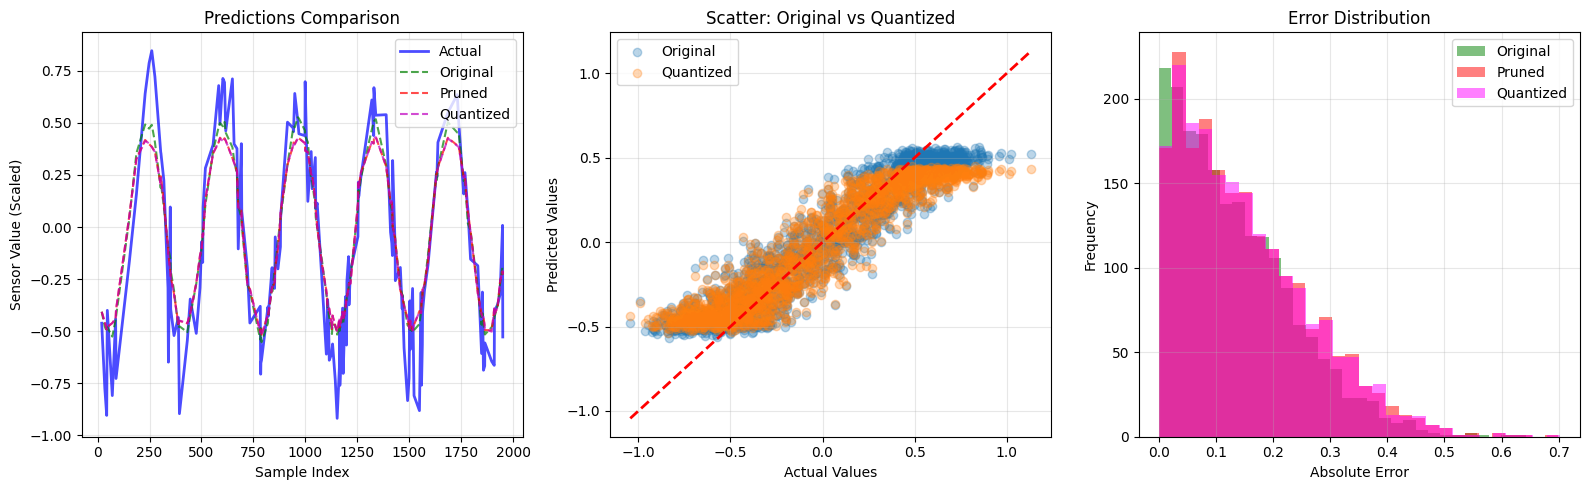

In [20]:
# Visualize predictions comparison
plt.figure(figsize=(16, 5))

num_samples = min(150, len(y_true_flat))
if num_samples > 0:
    indices = np.random.choice(len(y_true_flat), num_samples, replace=False)
    indices = np.sort(indices)

    # Plot 1: Time series comparison
    plt.subplot(1, 3, 1)
    plt.plot(indices, y_true_flat[indices], 'b-', label='Actual', alpha=0.7, linewidth=2)
    plt.plot(indices, y_pred_flat[indices], 'g--', label='Original', alpha=0.7)
    plt.plot(indices, y_pred_pruned.flatten()[indices], 'r--', label='Pruned', alpha=0.7)
    plt.plot(indices, y_pred_flat_quant[indices], 'm--', label='Quantized', alpha=0.7)
    plt.xlabel('Sample Index')
    plt.ylabel('Sensor Value (Scaled)')
    plt.title('Predictions Comparison')
    plt.legend()
    plt.grid(True, alpha=0.3)

    # Plot 2: Original vs Quantized scatter
    plt.subplot(1, 3, 2)
    plt.scatter(y_true_flat, y_pred_flat, alpha=0.3, label='Original')
    plt.scatter(y_true_flat, y_pred_flat_quant, alpha=0.3, label='Quantized')
    mn = min(y_true_flat.min(), y_pred_flat.min(), y_pred_flat_quant.min())
    mx = max(y_true_flat.max(), y_pred_flat.max(), y_pred_flat_quant.max())
    plt.plot([mn, mx], [mn, mx], 'r--', lw=2)
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.title('Scatter: Original vs Quantized')
    plt.legend()
    plt.grid(True, alpha=0.3)

    # Plot 3: Error distribution
    plt.subplot(1, 3, 3)
    error_original = np.abs(y_true_flat - y_pred_flat)
    error_pruned = np.abs(y_true_flat - y_pred_pruned.flatten())
    error_quantized = np.abs(y_true_flat - y_pred_flat_quant)
    
    plt.hist(error_original, bins=30, alpha=0.5, label='Original', color='green')
    plt.hist(error_pruned, bins=30, alpha=0.5, label='Pruned', color='red')
    plt.hist(error_quantized, bins=30, alpha=0.5, label='Quantized', color='magenta')
    plt.xlabel('Absolute Error')
    plt.ylabel('Frequency')
    plt.title('Error Distribution')
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()
else:
    print("No test samples available to plot.")